In [8]:
import pandas as pd
import numpy as np
import pandas_datareader.data as wb
import matplotlib.pyplot as plt
import string
import warnings
warnings.filterwarnings('ignore')
import requests

#Obtendo e Tratando dados

In [9]:
carteira = 1111
acao_codigo = 'BBSE3'
mm1 = ('MM20', 13)
mm2 = ('MM200', 200)
var = 20
dados = pd.DataFrame()
dados[acao_codigo] = wb.get_data_yahoo(acao_codigo+'.SA', start=2000)['Adj Close']
dados

,BBSE3
Date,
2013-04-29,9.819860
2013-04-30,10.086059
2013-05-02,10.352262
2013-05-03,10.500149
2013-05-06,10.606630
...,...
2020-12-21,28.969999
2020-12-22,29.160000
2020-12-23,29.129999


In [10]:
dados[mm1[0]] = dados[acao_codigo].rolling(mm1[1]).mean()
dados[mm2[0]] = dados[acao_codigo].rolling(mm2[1]).mean()
dados = dados.dropna()
print(dados)

                BBSE3       MM20      MM200
Date                                       
2014-02-13  14.527386  14.018461  12.609486
2014-02-14  14.376057  14.048726  12.632267
2014-02-17  14.630335  14.112520  12.654988
2014-02-18  14.493777  14.172328  12.675696
2014-02-19  14.562057  14.235525  12.696005
...               ...        ...        ...
2020-12-21  28.969999  29.390769  26.108944
2020-12-22  29.160000  29.423077  26.107145
2020-12-23  29.129999  29.453846  26.105003
2020-12-28  29.730000  29.512308  26.115995
2020-12-29  30.059999  29.620769  26.125678

[1705 rows x 3 columns]


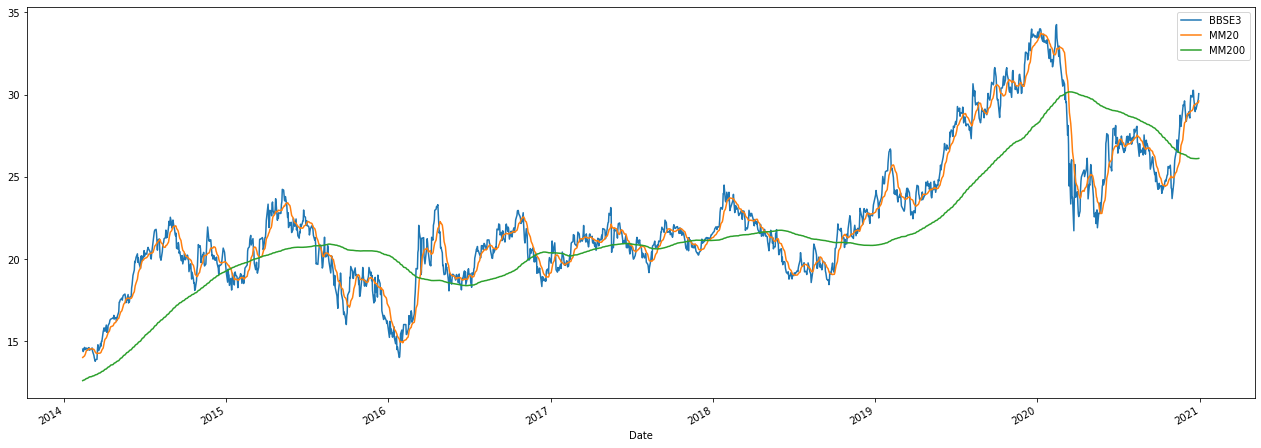

In [11]:
dados.plot(figsize=(22,8), label=acao_codigo)
plt.show()

In [12]:
def format_money(m):
    return f'R$ {m:.2f}'

In [13]:
n, lucro, h = 0, 0, 0
compra, vende = 0, 0
aporte = carteira
print(f'Carteira: {format_money(carteira)}')
stopAtivado = False
precoStopAtivado = 0
for i in dados.index:
    preco_acao = dados[acao_codigo][i]
    dia = f'{i.year}/{i.month:02}/{i.day:02}'
    # Comprando
    if dados[mm1[0]][i] >= dados[mm2[0]][i] and dados[mm1[0]][h] <= dados[mm2[0]][h] and compra == 0:
        n = int(carteira // preco_acao)
        carteira = carteira % preco_acao
        compra = preco_acao
        print(f'{dia} - Compra {n} acões à {format_money(compra)}...')
        print(f'Carteira: {format_money(carteira)}')
        stop_acao = preco_acao*(1-(var/100))
    elif stopAtivado and dados[mm1[0]][i] >= dados[mm2[0]][i] and precoStopAtivado <= preco_acao and compra == 0:
        n = int(carteira // preco_acao)
        carteira = carteira % preco_acao
        compra = preco_acao
        print(f'{dia} - Compra {n} acões à {format_money(compra)}...')
        print(f'Carteira: {format_money(carteira)}')
        stop_acao = preco_acao*(1-(var/100*2))
        stopAtivado = False

    # Vendendo
    elif compra != 0:
        menor_preco_acao = preco_acao*(1-(var/100))
        if menor_preco_acao > stop_acao:
            stop_acao = menor_preco_acao
            print(f'{dia} - Stop da açao foi para {format_money(stop_acao)}')
        elif dados[mm1[0]][i] <= dados[mm2[0]][i] and dados[mm1[0]][h] >= dados[mm2[0]][h] or preco_acao < stop_acao:
            if preco_acao < stop_acao:
                stopAtivado = True
                precoStopAtivado = preco_acao
                print(f"{'Foi stopado!':>60}")
            vende = preco_acao
            print(f'{dia} - Vende {n} ações à {format_money(vende)}...')
            luc_parcial = (vende - compra)*n
            if luc_parcial > 0:
                print(f';D Lucro de: {format_money(luc_parcial)}...\n')
            else:
                print(f':( Preju de: {format_money(luc_parcial)}...\n')
            lucro += luc_parcial
            carteira += (n*vende)
            print(f'Carteira: {format_money(carteira)}')
            compra, vende, n = 0, 0, 0
    elif dados[mm1[0]][i] <= dados[mm2[0]][i] and dados[mm1[0]][h] >= dados[mm2[0]][h]:
        stopAtivado = False
        precoStopAtivado = 9999999
    h = i

if compra != 0:
    vende = dados[acao_codigo][-1]
    print(f'{dia} - Vende {n} ações à {format_money(vende)}...')
    luc_parcial = (vende - compra)*n
    if luc_parcial > 0:
        print(f';D Lucro de: {format_money(luc_parcial)}...\n')
    else:
        print(f':( Preju de: {format_money(luc_parcial)}...\n')
    lucro += luc_parcial
    carteira += (n*vende)

print(f'Carteira: {format_money(carteira)}')
print(f'Lucro total: {format_money(lucro)}')
lucr_porc = lucro/aporte*100
print(f'Lucro de: {lucr_porc:.2f}%')

Carteira: R$ 1111.00
2015/02/27 - Compra 53 acões à R$ 20.86...
Carteira: R$ 5.57
2015/03/02 - Stop da açao foi para R$ 16.91
2015/03/03 - Stop da açao foi para R$ 17.00
2015/03/20 - Vende 53 ações à R$ 21.21...
;D Lucro de: R$ 18.56...

Carteira: R$ 1129.56
2015/03/23 - Compra 53 acões à R$ 21.27...
Carteira: R$ 2.13
2015/03/24 - Stop da açao foi para R$ 17.05
2015/03/31 - Stop da açao foi para R$ 17.05
2015/04/01 - Stop da açao foi para R$ 17.36
2015/04/02 - Stop da açao foi para R$ 17.88
2015/04/06 - Stop da açao foi para R$ 18.67
2015/04/15 - Stop da açao foi para R$ 18.68
2015/04/16 - Stop da açao foi para R$ 18.78
2015/04/23 - Stop da açao foi para R$ 18.94
2015/05/08 - Stop da açao foi para R$ 19.39
2015/07/31 - Vende 53 ações à R$ 20.89...
:( Preju de: R$ -20.28...

Carteira: R$ 1109.28
2016/03/14 - Compra 52 acões à R$ 21.16...
Carteira: R$ 8.87
2016/03/17 - Stop da açao foi para R$ 17.02
2016/03/21 - Stop da açao foi para R$ 17.05
2016/04/08 - Stop da açao foi para R$ 17.06
2

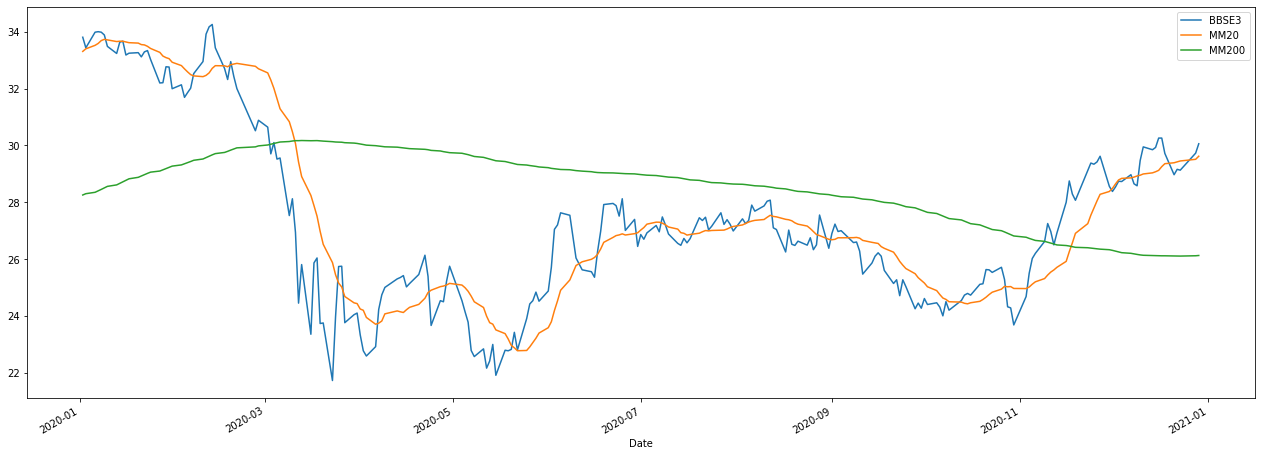

,BBSE3,MM20,MM200
Date,,,
2020-01-02,33.811050,33.312046,28.255666
2020-01-03,33.438335,33.402837,28.301335
2020-01-06,33.988541,33.525712,28.350750
2020-01-07,34.006287,33.591928,28.400599
2020-01-08,33.988541,33.692958,28.452263
...,...,...,...
2020-12-21,28.969999,29.390769,26.108944
2020-12-22,29.160000,29.423077,26.107145
2020-12-23,29.129999,29.453846,26.105003


In [14]:
dados_fatiado = dados[(dados.index.year == 2020)]
#dados_fatiado = dados_fatiado[(dados_fatiado.index.month == 3)]
dados_fatiado.plot(figsize=(22,8), label=acao_codigo)
plt.show()
dados_fatiado